# Setup MLFLOW for Experiment Tracking

In [1]:
#Setup MLflow for Data Tracking
#!pip install mlflow
#for MLFlow System Metric Tracking
#!pip install psutil pynvml

# Start the MLflow server
# mlflow server --host 127.0.0.1 --port 8080

import mlflow

mlflow.set_tracking_uri(uri="http://localhost:8080")

# set the experiment id
mlflow.set_experiment("Birds Classification")

2024/04/06 10:22:55 INFO mlflow.tracking.fluent: Experiment with name 'Birds Classification' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/407579555511193022', creation_time=1712391775733, experiment_id='407579555511193022', last_update_time=1712391775733, lifecycle_stage='active', name='Birds Classification', tags={}>

## 1. Download Data:

BIRDS 525 SPECIES- IMAGE CLASSIFICATION  
525 species, 84635 train, 2625 test, 2625 validation images 224X224X3 jpg  

https://www.kaggle.com/datasets/gpiosenka/100-bird-species?resource=download  

Save archive.zip file into data/ folder

## 2. Unzip Data:  

In [2]:
import zipfile

#zipfile.ZipFile('data/archive.zip', 'r').extractall('data/')

## 3. Load Data

In [3]:
import torch
from torch import nn
import torchvision
from torchvision import transforms

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 3.1 Set Datapath

In [4]:
from pathlib import Path
data_path = Path('data/')

train_path = data_path / 'train'
test_path = data_path / 'test'
valid_path = data_path / 'valid'

### 3.2 Visualize an image

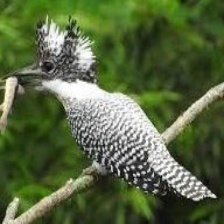

In [5]:
import random
from PIL import Image

image_path_list = list(data_path.glob('*/*/*.jpg'))
random_image_path = random.choice(image_path_list)

# Turn the image into an array
img = Image.open(random_image_path)
img

### 3.3 Get the transform for Image-Modifikation from the weights of the pertrained Model

Before using the pre-trained models, one must preprocess the image (resize with right resolution/interpolation, apply inference transforms, rescale the values etc). There is no standard way to do this as it depends on how a given model was trained. It can vary across model families, variants or even weight versions. Using the correct preprocessing method is critical and failing to do so may lead to decreased accuracy or incorrect outputs.

All the necessary information for the inference transforms of each pre-trained model is provided on its weights documentation. To simplify inference, TorchVision bundles the necessary preprocessing transforms into each model weight. These are accessible via the weight.transforms attribute:

In [6]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 3.4 Create Datasets with ImageFolder

In [7]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_path, # target folder of images
                                  transform=auto_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_path, 
                                 transform=auto_transforms)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 84635
    Root location: data/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 2625
    Root location: data/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )


In [8]:
# Get class names as a list
class_names = train_data.classes

# Get number of classes
len(class_names)

525

In [9]:
# Check the lengths
len(train_data), len(test_data)

(84635, 2625)

In [10]:
# Get the first image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[ 1.7180,  1.7009,  1.6838,  ...,  2.1633,  2.1804,  2.1290],
         [ 1.7180,  1.7009,  1.7009,  ...,  2.1804,  2.1290,  2.0605],
         [ 1.7352,  1.7352,  1.7352,  ...,  2.1633,  2.0605,  2.0092],
         ...,
         [ 1.4269,  1.2728,  1.0502,  ..., -1.3473, -1.3302, -1.3644],
         [ 0.8789,  0.5707,  0.2967,  ..., -1.3302, -1.3302, -1.3644],
         [-0.1999, -0.1828, -0.0116,  ..., -1.3130, -1.3302, -1.4158]],

        [[ 1.7808,  1.7633,  1.7283,  ...,  2.1835,  2.2185,  2.1660],
         [ 1.7458,  1.7283,  1.7108,  ...,  2.2010,  2.1660,  2.1134],
         [ 1.7108,  1.7108,  1.6933,  ...,  2.2010,  2.1485,  2.1310],
         ...,
         [ 1.4482,  1.2906,  1.0805,  ..., -1.2129, -1.2304, -1.2654],
         [ 0.8004,  0.4678,  0.2227,  ..., -1.1954, -1.2129, -1.2479],
         [-0.3550, -0.3550, -0.1450,  ..., -1.2129, -1.2479, -1.3354]],

        [[ 1.7511,  1.7337,  1.7163,  ...,  2.2217,  2.2391,  2.1520],
         [ 1.7685,  1.7511,  1.

### 3.5 Turn loaded images into Dataloaders

In [11]:
# Batchsize
batch_size = 32

# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=batch_size, # how many samples per batch?
                              num_workers=4, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=batch_size, 
                             num_workers=4, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f9b7078d720>,
 <torch.utils.data.dataloader.DataLoader at 0x7f9b7078d000>)

### 3.5.1 View a DataLoader example for the first batch

In [12]:
for batch,(X,y) in enumerate(test_dataloader):
    print(f"Batch number: {batch}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    print(f"y-Classes:")
    print(f"y: {y}")
    break

Batch number: 0
X shape: torch.Size([32, 3, 224, 224])
y shape: torch.Size([32])
y-Classes:
y: tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 5, 5, 5, 5, 5, 6, 6])


## 4. Getting a pretrained model

### 4.1 Setting up pretrained model

In [13]:
#Function for Model creation
def create_model(weights, class_names):
    
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)
    
    # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
    for param in model.features.parameters():
        param.requires_grad = False
        
    # Get the length of class_names (one output unit for each class)
    output_shape = len(class_names)

    # Recreate the classifier layer and seed it to the target device
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True), 
        torch.nn.Linear(in_features=1280, 
                        out_features=output_shape, # same number of output units as our number of classes
                        bias=True)).to(device)
    
    return model

# 5. Define Test//train Functions

In [14]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device) 

    # 1. Forward pass
    y_pred = model(X)
    # print(y_pred)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc 

 Erklärung:  
 y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)  

Die ausgewählte Zeile aus dem Python-Code führt eine Klassifikation auf den Vorhersagen `y_pred` eines Modells durch. Hier ist eine detaillierte Erklärung:

1. `torch.softmax(y_pred, dim=1)`: Die Softmax-Funktion wird auf `y_pred` angewendet. Softmax ist eine Funktion, die die Ausgaben eines Modells in Wahrscheinlichkeiten umwandelt, die sich zu 1 addieren. Der Parameter `dim=1` bedeutet, dass die Softmax-Funktion entlang der Spalten angewendet wird (d.h., für jede Zeile werden die Werte so skaliert, dass sie sich zu 1 addieren).

2. `torch.argmax(...)`: Die Funktion `argmax` gibt den Index des größten Wertes in einem Tensor zurück. In diesem Kontext wird es verwendet, um den Index der Klasse mit der höchsten Wahrscheinlichkeit zu bestimmen. Wiederum bedeutet `dim=1`, dass die Funktion entlang der Spalten angewendet wird (d.h., für jede Zeile wird der Index des größten Wertes zurückgegeben).

Zusammengefasst: Diese Zeile wandelt die Ausgaben des Modells in Wahrscheinlichkeiten um und wählt dann die Klasse mit der höchsten Wahrscheinlichkeit als Vorhersage für jede Eingabe aus.

In [15]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)
      # print(test_pred_logits)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    
  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [16]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          learning_rate: float = 0.001):
    
    # Create results dictionary
    results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  

# Starten Sie ein neues MLflow Run
    with mlflow.start_run(log_system_metrics=True):
            # Protokollieren Sie Parameter
            mlflow.log_param("loss_fn", loss_fn)
            mlflow.log_param("optimizer", optimizer)
            mlflow.log_param("epochs", epochs)
            mlflow.log_param("learning_rate", learning_rate)
        
            # Loop through the training and testing steps for a number of epochs
            for epoch in tqdm(range(epochs)):
                # Train step
                train_loss, train_acc = train_step(model=model, 
                                                dataloader=train_dataloader,
                                                loss_fn=loss_fn,
                                                optimizer=optimizer)
                # Test step
                test_loss, test_acc = test_step(model=model, 
                                                dataloader=test_dataloader,
                                                loss_fn=loss_fn)
                
                # Print out what's happening to mlfow
                mlflow.log_metric("train_loss", train_loss, step=epoch)
                mlflow.log_metric("train_acc", train_acc, step=epoch)
                mlflow.log_metric("test_loss", test_loss, step=epoch)
                mlflow.log_metric("test_acc", test_acc, step=epoch)
                
                
                # Print out what's happening to the console
                print(f"Epoch: {epoch+1} | "
                    f"train_loss: {train_loss:.4f} | "
                    f"train_acc: {train_acc:.4f} | "
                    f"test_loss: {test_loss:.4f} | "
                    f"test_acc: {test_acc:.4f}"
                )

                # Update the results dictionary
                results["train_loss"].append(train_loss)
                results["train_acc"].append(train_acc)
                results["test_loss"].append(test_loss)
                results["test_acc"].append(test_acc)


    return results

## 5.1 Define Loss and Optimizer

In [17]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

## 5.2 Train Model

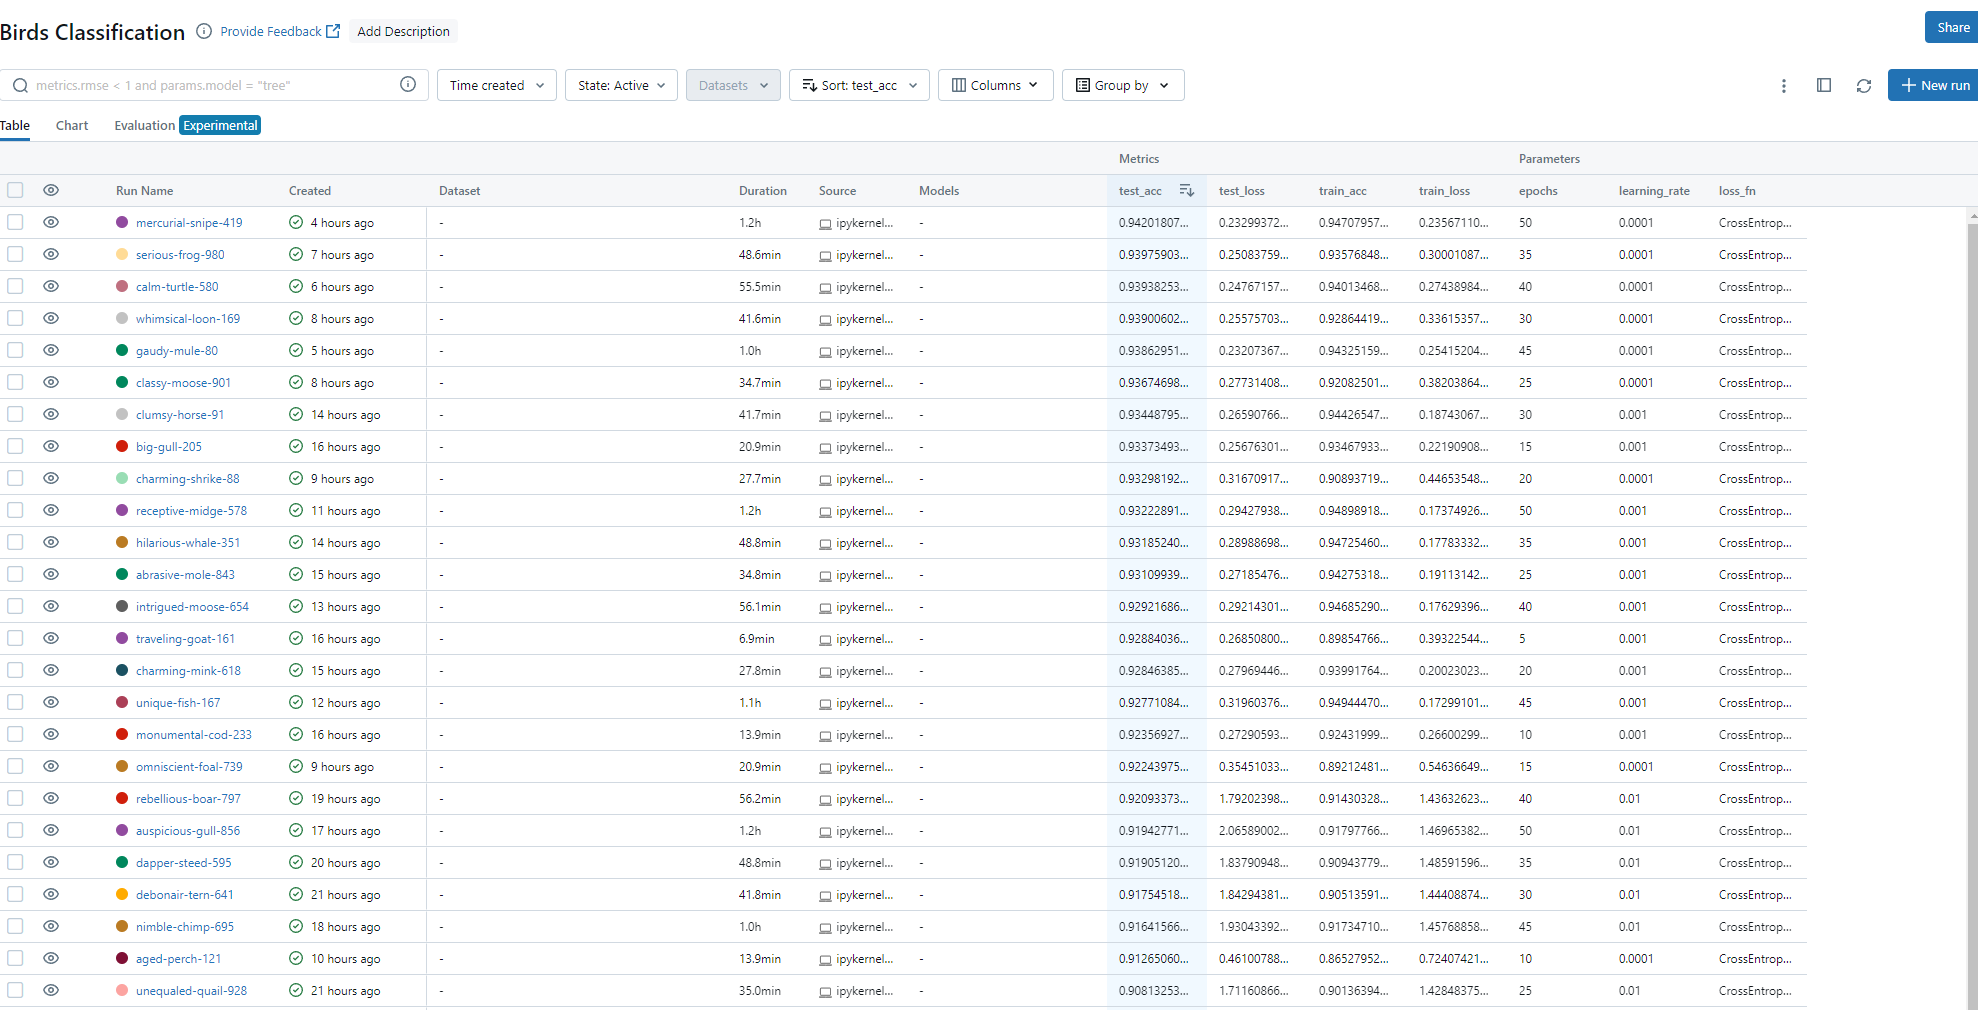

In [18]:
for learning_rate in [0.01, 0.001, 0.0001]:
    for epochs in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
        print(f"------Lerning Rate: {learning_rate} -------Epochs: {epochs} -------------")
        model = create_model(weights=weights, class_names=class_names)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        model_results = train(model=model,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            optimizer=optimizer,
                            epochs=epochs,
                            learning_rate=learning_rate)


------Lerning Rate: 0.01 -------Epochs: 5 -------------


2024/04/06 10:22:58 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7780 | train_acc: 0.5892 | test_loss: 0.9875 | test_acc: 0.8404
Epoch: 2 | train_loss: 2.0668 | train_acc: 0.7394 | test_loss: 1.0666 | test_acc: 0.8648
Epoch: 3 | train_loss: 1.9418 | train_acc: 0.7744 | test_loss: 1.1457 | test_acc: 0.8773
Epoch: 4 | train_loss: 1.8142 | train_acc: 0.8027 | test_loss: 1.2020 | test_acc: 0.8671


2024/04/06 10:30:07 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 10:30:07 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 10:30:08 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 5 | train_loss: 1.7716 | train_acc: 0.8169 | test_loss: 1.2475 | test_acc: 0.8822
------Lerning Rate: 0.01 -------Epochs: 10 -------------


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7741 | train_acc: 0.5899 | test_loss: 1.0754 | test_acc: 0.8306
Epoch: 2 | train_loss: 2.0556 | train_acc: 0.7399 | test_loss: 1.1231 | test_acc: 0.8566
Epoch: 3 | train_loss: 1.9309 | train_acc: 0.7774 | test_loss: 1.1170 | test_acc: 0.8761
Epoch: 4 | train_loss: 1.8447 | train_acc: 0.7983 | test_loss: 1.2903 | test_acc: 0.8712
Epoch: 5 | train_loss: 1.7569 | train_acc: 0.8154 | test_loss: 1.0841 | test_acc: 0.8886
Epoch: 6 | train_loss: 1.7049 | train_acc: 0.8306 | test_loss: 1.1876 | test_acc: 0.8995
Epoch: 7 | train_loss: 1.6645 | train_acc: 0.8408 | test_loss: 1.3363 | test_acc: 0.8874
Epoch: 8 | train_loss: 1.6351 | train_acc: 0.8486 | test_loss: 1.3096 | test_acc: 0.8942
Epoch: 9 | train_loss: 1.6148 | train_acc: 0.8542 | test_loss: 1.2021 | test_acc: 0.8998


2024/04/06 10:44:23 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 10:44:23 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 10:44:23 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 10 | train_loss: 1.5801 | train_acc: 0.8609 | test_loss: 1.3538 | test_acc: 0.8968
------Lerning Rate: 0.01 -------Epochs: 15 -------------


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7672 | train_acc: 0.5884 | test_loss: 1.0662 | test_acc: 0.8358
Epoch: 2 | train_loss: 2.0650 | train_acc: 0.7392 | test_loss: 1.1950 | test_acc: 0.8547
Epoch: 3 | train_loss: 1.9244 | train_acc: 0.7772 | test_loss: 1.1955 | test_acc: 0.8633
Epoch: 4 | train_loss: 1.8201 | train_acc: 0.8012 | test_loss: 1.2290 | test_acc: 0.8818
Epoch: 5 | train_loss: 1.7576 | train_acc: 0.8173 | test_loss: 1.1340 | test_acc: 0.8931
Epoch: 6 | train_loss: 1.6813 | train_acc: 0.8316 | test_loss: 1.2270 | test_acc: 0.8897
Epoch: 7 | train_loss: 1.6725 | train_acc: 0.8398 | test_loss: 1.3681 | test_acc: 0.8882
Epoch: 8 | train_loss: 1.6365 | train_acc: 0.8491 | test_loss: 1.3537 | test_acc: 0.8950
Epoch: 9 | train_loss: 1.5984 | train_acc: 0.8552 | test_loss: 1.3082 | test_acc: 0.9010
Epoch: 10 | train_loss: 1.5981 | train_acc: 0.8601 | test_loss: 1.3716 | test_acc: 0.9040
Epoch: 11 | train_loss: 1.5540 | train_acc: 0.8664 | test_loss: 1.3959 | test_acc: 0.9036
Epoch: 12 | train_l

2024/04/06 11:05:15 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 11:05:15 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 11:05:15 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 15 | train_loss: 1.5333 | train_acc: 0.8794 | test_loss: 1.5047 | test_acc: 0.9081
------Lerning Rate: 0.01 -------Epochs: 20 -------------


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7625 | train_acc: 0.5892 | test_loss: 1.0849 | test_acc: 0.8381
Epoch: 2 | train_loss: 2.0750 | train_acc: 0.7389 | test_loss: 1.0585 | test_acc: 0.8554
Epoch: 3 | train_loss: 1.9127 | train_acc: 0.7781 | test_loss: 1.1923 | test_acc: 0.8581
Epoch: 4 | train_loss: 1.8193 | train_acc: 0.8012 | test_loss: 1.2249 | test_acc: 0.8799
Epoch: 5 | train_loss: 1.7780 | train_acc: 0.8159 | test_loss: 1.1635 | test_acc: 0.8889
Epoch: 6 | train_loss: 1.7303 | train_acc: 0.8287 | test_loss: 1.1792 | test_acc: 0.8897
Epoch: 7 | train_loss: 1.6406 | train_acc: 0.8409 | test_loss: 1.2752 | test_acc: 0.8950
Epoch: 8 | train_loss: 1.6199 | train_acc: 0.8492 | test_loss: 1.1910 | test_acc: 0.8965
Epoch: 9 | train_loss: 1.6199 | train_acc: 0.8553 | test_loss: 1.2447 | test_acc: 0.9025
Epoch: 10 | train_loss: 1.5994 | train_acc: 0.8614 | test_loss: 1.3094 | test_acc: 0.9017
Epoch: 11 | train_loss: 1.5792 | train_acc: 0.8647 | test_loss: 1.4718 | test_acc: 0.8991
Epoch: 12 | train_l

2024/04/06 11:33:04 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 11:33:04 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 11:33:04 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 20 | train_loss: 1.4455 | train_acc: 0.8926 | test_loss: 1.6846 | test_acc: 0.9047
------Lerning Rate: 0.01 -------Epochs: 25 -------------


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7618 | train_acc: 0.5897 | test_loss: 1.0706 | test_acc: 0.8392
Epoch: 2 | train_loss: 2.0745 | train_acc: 0.7393 | test_loss: 1.0432 | test_acc: 0.8648
Epoch: 3 | train_loss: 1.9210 | train_acc: 0.7782 | test_loss: 1.2071 | test_acc: 0.8735
Epoch: 4 | train_loss: 1.8412 | train_acc: 0.8012 | test_loss: 1.1197 | test_acc: 0.8863
Epoch: 5 | train_loss: 1.7508 | train_acc: 0.8186 | test_loss: 1.2165 | test_acc: 0.8848
Epoch: 6 | train_loss: 1.7139 | train_acc: 0.8306 | test_loss: 1.1378 | test_acc: 0.8908
Epoch: 7 | train_loss: 1.6920 | train_acc: 0.8383 | test_loss: 1.2370 | test_acc: 0.8972
Epoch: 8 | train_loss: 1.6188 | train_acc: 0.8492 | test_loss: 1.2840 | test_acc: 0.9021
Epoch: 9 | train_loss: 1.6150 | train_acc: 0.8542 | test_loss: 1.4190 | test_acc: 0.8965
Epoch: 10 | train_loss: 1.5907 | train_acc: 0.8607 | test_loss: 1.4138 | test_acc: 0.8965
Epoch: 11 | train_loss: 1.5971 | train_acc: 0.8643 | test_loss: 1.4331 | test_acc: 0.9006
Epoch: 12 | train_l

2024/04/06 12:08:03 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 12:08:03 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 12:08:03 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 25 | train_loss: 1.4285 | train_acc: 0.9014 | test_loss: 1.7116 | test_acc: 0.9081
------Lerning Rate: 0.01 -------Epochs: 30 -------------


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7688 | train_acc: 0.5876 | test_loss: 0.9907 | test_acc: 0.8494
Epoch: 2 | train_loss: 2.0649 | train_acc: 0.7391 | test_loss: 1.1838 | test_acc: 0.8498
Epoch: 3 | train_loss: 1.9534 | train_acc: 0.7752 | test_loss: 1.2238 | test_acc: 0.8697
Epoch: 4 | train_loss: 1.8328 | train_acc: 0.8006 | test_loss: 1.1667 | test_acc: 0.8806
Epoch: 5 | train_loss: 1.7807 | train_acc: 0.8172 | test_loss: 1.0878 | test_acc: 0.8946
Epoch: 6 | train_loss: 1.7331 | train_acc: 0.8298 | test_loss: 1.2499 | test_acc: 0.8950
Epoch: 7 | train_loss: 1.6679 | train_acc: 0.8394 | test_loss: 1.2215 | test_acc: 0.8919
Epoch: 8 | train_loss: 1.6494 | train_acc: 0.8475 | test_loss: 1.2926 | test_acc: 0.8965
Epoch: 9 | train_loss: 1.6433 | train_acc: 0.8531 | test_loss: 1.3394 | test_acc: 0.8980
Epoch: 10 | train_loss: 1.6165 | train_acc: 0.8595 | test_loss: 1.4607 | test_acc: 0.8968
Epoch: 11 | train_loss: 1.5893 | train_acc: 0.8647 | test_loss: 1.4190 | test_acc: 0.8980
Epoch: 12 | train_l

2024/04/06 12:49:49 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 12:49:49 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 12:49:50 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 30 | train_loss: 1.4441 | train_acc: 0.9051 | test_loss: 1.8429 | test_acc: 0.9175
------Lerning Rate: 0.01 -------Epochs: 35 -------------


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7569 | train_acc: 0.5890 | test_loss: 1.1712 | test_acc: 0.8328
Epoch: 2 | train_loss: 2.0853 | train_acc: 0.7393 | test_loss: 1.1457 | test_acc: 0.8611
Epoch: 3 | train_loss: 1.9453 | train_acc: 0.7762 | test_loss: 1.0657 | test_acc: 0.8803
Epoch: 4 | train_loss: 1.8181 | train_acc: 0.8008 | test_loss: 1.1380 | test_acc: 0.8829
Epoch: 5 | train_loss: 1.7714 | train_acc: 0.8163 | test_loss: 1.2566 | test_acc: 0.8829
Epoch: 6 | train_loss: 1.7135 | train_acc: 0.8298 | test_loss: 1.2364 | test_acc: 0.8931
Epoch: 7 | train_loss: 1.6775 | train_acc: 0.8405 | test_loss: 1.2934 | test_acc: 0.8927
Epoch: 8 | train_loss: 1.6220 | train_acc: 0.8494 | test_loss: 1.4804 | test_acc: 0.8904
Epoch: 9 | train_loss: 1.6115 | train_acc: 0.8555 | test_loss: 1.3909 | test_acc: 0.8934
Epoch: 10 | train_loss: 1.6194 | train_acc: 0.8598 | test_loss: 1.3878 | test_acc: 0.8987
Epoch: 11 | train_loss: 1.5503 | train_acc: 0.8667 | test_loss: 1.3193 | test_acc: 0.9044
Epoch: 12 | train_l

2024/04/06 13:38:39 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 13:38:39 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 13:38:39 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 35 | train_loss: 1.4859 | train_acc: 0.9094 | test_loss: 1.8379 | test_acc: 0.9191
------Lerning Rate: 0.01 -------Epochs: 40 -------------


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7553 | train_acc: 0.5902 | test_loss: 1.0753 | test_acc: 0.8328
Epoch: 2 | train_loss: 2.0683 | train_acc: 0.7401 | test_loss: 1.1029 | test_acc: 0.8592
Epoch: 3 | train_loss: 1.8969 | train_acc: 0.7768 | test_loss: 1.1237 | test_acc: 0.8784
Epoch: 4 | train_loss: 1.8175 | train_acc: 0.8015 | test_loss: 1.0513 | test_acc: 0.8878
Epoch: 5 | train_loss: 1.7709 | train_acc: 0.8180 | test_loss: 1.0767 | test_acc: 0.8840
Epoch: 6 | train_loss: 1.7187 | train_acc: 0.8295 | test_loss: 1.2712 | test_acc: 0.8912
Epoch: 7 | train_loss: 1.6474 | train_acc: 0.8419 | test_loss: 1.2715 | test_acc: 0.8878
Epoch: 8 | train_loss: 1.6333 | train_acc: 0.8482 | test_loss: 1.3384 | test_acc: 0.8912
Epoch: 9 | train_loss: 1.5821 | train_acc: 0.8560 | test_loss: 1.4216 | test_acc: 0.8919
Epoch: 10 | train_loss: 1.5958 | train_acc: 0.8599 | test_loss: 1.3425 | test_acc: 0.8972
Epoch: 11 | train_loss: 1.5570 | train_acc: 0.8663 | test_loss: 1.5593 | test_acc: 0.8987
Epoch: 12 | train_l

2024/04/06 14:34:52 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 14:34:52 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 14:34:52 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 40 | train_loss: 1.4363 | train_acc: 0.9143 | test_loss: 1.7920 | test_acc: 0.9209
------Lerning Rate: 0.01 -------Epochs: 45 -------------


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7661 | train_acc: 0.5904 | test_loss: 1.0010 | test_acc: 0.8389
Epoch: 2 | train_loss: 2.0696 | train_acc: 0.7397 | test_loss: 1.0647 | test_acc: 0.8645
Epoch: 3 | train_loss: 1.9431 | train_acc: 0.7765 | test_loss: 1.1137 | test_acc: 0.8705
Epoch: 4 | train_loss: 1.8443 | train_acc: 0.8011 | test_loss: 1.2403 | test_acc: 0.8739
Epoch: 5 | train_loss: 1.7744 | train_acc: 0.8161 | test_loss: 1.1942 | test_acc: 0.8818
Epoch: 6 | train_loss: 1.7054 | train_acc: 0.8308 | test_loss: 1.2825 | test_acc: 0.8916
Epoch: 7 | train_loss: 1.6809 | train_acc: 0.8404 | test_loss: 1.3557 | test_acc: 0.8919
Epoch: 8 | train_loss: 1.6218 | train_acc: 0.8483 | test_loss: 1.2572 | test_acc: 0.8995
Epoch: 9 | train_loss: 1.6105 | train_acc: 0.8559 | test_loss: 1.2878 | test_acc: 0.8998
Epoch: 10 | train_loss: 1.5962 | train_acc: 0.8604 | test_loss: 1.2460 | test_acc: 0.9059
Epoch: 11 | train_loss: 1.5548 | train_acc: 0.8653 | test_loss: 1.3581 | test_acc: 0.9014
Epoch: 12 | train_l

2024/04/06 15:37:31 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 15:37:31 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 15:37:31 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 45 | train_loss: 1.4577 | train_acc: 0.9173 | test_loss: 1.9304 | test_acc: 0.9164
------Lerning Rate: 0.01 -------Epochs: 50 -------------


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7714 | train_acc: 0.5894 | test_loss: 1.0854 | test_acc: 0.8264
Epoch: 2 | train_loss: 2.0521 | train_acc: 0.7400 | test_loss: 1.0570 | test_acc: 0.8660
Epoch: 3 | train_loss: 1.9156 | train_acc: 0.7773 | test_loss: 1.1199 | test_acc: 0.8656
Epoch: 4 | train_loss: 1.8487 | train_acc: 0.7994 | test_loss: 1.1522 | test_acc: 0.8874
Epoch: 5 | train_loss: 1.7447 | train_acc: 0.8185 | test_loss: 1.2762 | test_acc: 0.8746
Epoch: 6 | train_loss: 1.7166 | train_acc: 0.8298 | test_loss: 1.1607 | test_acc: 0.8980
Epoch: 7 | train_loss: 1.6412 | train_acc: 0.8419 | test_loss: 1.2931 | test_acc: 0.9010
Epoch: 8 | train_loss: 1.6157 | train_acc: 0.8482 | test_loss: 1.3559 | test_acc: 0.8998
Epoch: 9 | train_loss: 1.6079 | train_acc: 0.8546 | test_loss: 1.4433 | test_acc: 0.8934
Epoch: 10 | train_loss: 1.6059 | train_acc: 0.8597 | test_loss: 1.3821 | test_acc: 0.9014
Epoch: 11 | train_loss: 1.5606 | train_acc: 0.8645 | test_loss: 1.4555 | test_acc: 0.9017
Epoch: 12 | train_l

2024/04/06 16:47:02 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 16:47:02 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 16:47:02 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 50 | train_loss: 1.4697 | train_acc: 0.9180 | test_loss: 2.0659 | test_acc: 0.9194
------Lerning Rate: 0.001 -------Epochs: 5 -------------


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8977 | train_acc: 0.6617 | test_loss: 0.5191 | test_acc: 0.8870
Epoch: 2 | train_loss: 0.7480 | train_acc: 0.8321 | test_loss: 0.3730 | test_acc: 0.9111
Epoch: 3 | train_loss: 0.5551 | train_acc: 0.8679 | test_loss: 0.3129 | test_acc: 0.9183
Epoch: 4 | train_loss: 0.4556 | train_acc: 0.8868 | test_loss: 0.2905 | test_acc: 0.9224


2024/04/06 16:53:59 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 16:53:59 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 16:53:59 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 5 | train_loss: 0.3932 | train_acc: 0.8985 | test_loss: 0.2685 | test_acc: 0.9288
------Lerning Rate: 0.001 -------Epochs: 10 -------------


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8988 | train_acc: 0.6609 | test_loss: 0.5026 | test_acc: 0.8946
Epoch: 2 | train_loss: 0.7493 | train_acc: 0.8330 | test_loss: 0.3665 | test_acc: 0.9168
Epoch: 3 | train_loss: 0.5526 | train_acc: 0.8671 | test_loss: 0.3042 | test_acc: 0.9217
Epoch: 4 | train_loss: 0.4579 | train_acc: 0.8860 | test_loss: 0.2896 | test_acc: 0.9243
Epoch: 5 | train_loss: 0.3946 | train_acc: 0.8982 | test_loss: 0.2832 | test_acc: 0.9273
Epoch: 6 | train_loss: 0.3542 | train_acc: 0.9053 | test_loss: 0.2711 | test_acc: 0.9281
Epoch: 7 | train_loss: 0.3208 | train_acc: 0.9139 | test_loss: 0.2670 | test_acc: 0.9277
Epoch: 8 | train_loss: 0.2991 | train_acc: 0.9173 | test_loss: 0.2558 | test_acc: 0.9341
Epoch: 9 | train_loss: 0.2758 | train_acc: 0.9226 | test_loss: 0.2730 | test_acc: 0.9307


2024/04/06 17:07:53 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 17:07:53 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 17:07:53 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 10 | train_loss: 0.2660 | train_acc: 0.9243 | test_loss: 0.2729 | test_acc: 0.9236
------Lerning Rate: 0.001 -------Epochs: 15 -------------


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8977 | train_acc: 0.6613 | test_loss: 0.5267 | test_acc: 0.8927
Epoch: 2 | train_loss: 0.7429 | train_acc: 0.8323 | test_loss: 0.3630 | test_acc: 0.9130
Epoch: 3 | train_loss: 0.5541 | train_acc: 0.8672 | test_loss: 0.3314 | test_acc: 0.9179
Epoch: 4 | train_loss: 0.4543 | train_acc: 0.8870 | test_loss: 0.2986 | test_acc: 0.9164
Epoch: 5 | train_loss: 0.3979 | train_acc: 0.8981 | test_loss: 0.2892 | test_acc: 0.9221
Epoch: 6 | train_loss: 0.3508 | train_acc: 0.9078 | test_loss: 0.2826 | test_acc: 0.9251
Epoch: 7 | train_loss: 0.3238 | train_acc: 0.9121 | test_loss: 0.2578 | test_acc: 0.9292
Epoch: 8 | train_loss: 0.2980 | train_acc: 0.9179 | test_loss: 0.2805 | test_acc: 0.9258
Epoch: 9 | train_loss: 0.2806 | train_acc: 0.9202 | test_loss: 0.2707 | test_acc: 0.9258
Epoch: 10 | train_loss: 0.2599 | train_acc: 0.9266 | test_loss: 0.2591 | test_acc: 0.9303
Epoch: 11 | train_loss: 0.2492 | train_acc: 0.9286 | test_loss: 0.2545 | test_acc: 0.9322
Epoch: 12 | train_l

2024/04/06 17:28:45 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 17:28:45 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 17:28:45 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 15 | train_loss: 0.2219 | train_acc: 0.9347 | test_loss: 0.2568 | test_acc: 0.9337
------Lerning Rate: 0.001 -------Epochs: 20 -------------


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9060 | train_acc: 0.6584 | test_loss: 0.5084 | test_acc: 0.8965
Epoch: 2 | train_loss: 0.7461 | train_acc: 0.8321 | test_loss: 0.3525 | test_acc: 0.9145
Epoch: 3 | train_loss: 0.5567 | train_acc: 0.8659 | test_loss: 0.3231 | test_acc: 0.9179
Epoch: 4 | train_loss: 0.4583 | train_acc: 0.8863 | test_loss: 0.2894 | test_acc: 0.9303
Epoch: 5 | train_loss: 0.3933 | train_acc: 0.8987 | test_loss: 0.2822 | test_acc: 0.9266
Epoch: 6 | train_loss: 0.3528 | train_acc: 0.9067 | test_loss: 0.2727 | test_acc: 0.9288
Epoch: 7 | train_loss: 0.3185 | train_acc: 0.9134 | test_loss: 0.2535 | test_acc: 0.9352
Epoch: 8 | train_loss: 0.2974 | train_acc: 0.9188 | test_loss: 0.2573 | test_acc: 0.9292
Epoch: 9 | train_loss: 0.2745 | train_acc: 0.9229 | test_loss: 0.2549 | test_acc: 0.9277
Epoch: 10 | train_loss: 0.2611 | train_acc: 0.9266 | test_loss: 0.2756 | test_acc: 0.9273
Epoch: 11 | train_loss: 0.2542 | train_acc: 0.9273 | test_loss: 0.2601 | test_acc: 0.9349
Epoch: 12 | train_l

2024/04/06 17:56:30 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 17:56:30 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 17:56:31 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 20 | train_loss: 0.2002 | train_acc: 0.9399 | test_loss: 0.2797 | test_acc: 0.9285
------Lerning Rate: 0.001 -------Epochs: 25 -------------


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9004 | train_acc: 0.6607 | test_loss: 0.5028 | test_acc: 0.8927
Epoch: 2 | train_loss: 0.7441 | train_acc: 0.8322 | test_loss: 0.3500 | test_acc: 0.9168
Epoch: 3 | train_loss: 0.5508 | train_acc: 0.8681 | test_loss: 0.3051 | test_acc: 0.9251
Epoch: 4 | train_loss: 0.4541 | train_acc: 0.8865 | test_loss: 0.2798 | test_acc: 0.9239
Epoch: 5 | train_loss: 0.3902 | train_acc: 0.8987 | test_loss: 0.2605 | test_acc: 0.9326
Epoch: 6 | train_loss: 0.3492 | train_acc: 0.9065 | test_loss: 0.2669 | test_acc: 0.9296
Epoch: 7 | train_loss: 0.3222 | train_acc: 0.9129 | test_loss: 0.2595 | test_acc: 0.9251
Epoch: 8 | train_loss: 0.2961 | train_acc: 0.9186 | test_loss: 0.2611 | test_acc: 0.9296
Epoch: 9 | train_loss: 0.2803 | train_acc: 0.9218 | test_loss: 0.2581 | test_acc: 0.9307
Epoch: 10 | train_loss: 0.2674 | train_acc: 0.9242 | test_loss: 0.2344 | test_acc: 0.9375
Epoch: 11 | train_loss: 0.2492 | train_acc: 0.9286 | test_loss: 0.2583 | test_acc: 0.9300
Epoch: 12 | train_l

2024/04/06 18:31:17 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 18:31:17 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 18:31:17 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 25 | train_loss: 0.1911 | train_acc: 0.9428 | test_loss: 0.2719 | test_acc: 0.9311
------Lerning Rate: 0.001 -------Epochs: 30 -------------


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9000 | train_acc: 0.6603 | test_loss: 0.5199 | test_acc: 0.8919
Epoch: 2 | train_loss: 0.7430 | train_acc: 0.8325 | test_loss: 0.3708 | test_acc: 0.9111
Epoch: 3 | train_loss: 0.5535 | train_acc: 0.8684 | test_loss: 0.3148 | test_acc: 0.9281
Epoch: 4 | train_loss: 0.4529 | train_acc: 0.8866 | test_loss: 0.2885 | test_acc: 0.9198
Epoch: 5 | train_loss: 0.3976 | train_acc: 0.8970 | test_loss: 0.2745 | test_acc: 0.9224
Epoch: 6 | train_loss: 0.3521 | train_acc: 0.9061 | test_loss: 0.2724 | test_acc: 0.9236
Epoch: 7 | train_loss: 0.3203 | train_acc: 0.9138 | test_loss: 0.2668 | test_acc: 0.9255
Epoch: 8 | train_loss: 0.2950 | train_acc: 0.9182 | test_loss: 0.2649 | test_acc: 0.9288
Epoch: 9 | train_loss: 0.2814 | train_acc: 0.9207 | test_loss: 0.2611 | test_acc: 0.9307
Epoch: 10 | train_loss: 0.2613 | train_acc: 0.9252 | test_loss: 0.2638 | test_acc: 0.9281
Epoch: 11 | train_loss: 0.2485 | train_acc: 0.9290 | test_loss: 0.2719 | test_acc: 0.9307
Epoch: 12 | train_l

2024/04/06 19:12:59 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 19:12:59 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 19:12:59 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 30 | train_loss: 0.1874 | train_acc: 0.9443 | test_loss: 0.2659 | test_acc: 0.9345
------Lerning Rate: 0.001 -------Epochs: 35 -------------


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9046 | train_acc: 0.6589 | test_loss: 0.5070 | test_acc: 0.8965
Epoch: 2 | train_loss: 0.7421 | train_acc: 0.8335 | test_loss: 0.3697 | test_acc: 0.9142
Epoch: 3 | train_loss: 0.5582 | train_acc: 0.8660 | test_loss: 0.3065 | test_acc: 0.9209
Epoch: 4 | train_loss: 0.4562 | train_acc: 0.8862 | test_loss: 0.2962 | test_acc: 0.9217
Epoch: 5 | train_loss: 0.3917 | train_acc: 0.8984 | test_loss: 0.2840 | test_acc: 0.9213
Epoch: 6 | train_loss: 0.3512 | train_acc: 0.9066 | test_loss: 0.2683 | test_acc: 0.9277
Epoch: 7 | train_loss: 0.3228 | train_acc: 0.9127 | test_loss: 0.2638 | test_acc: 0.9243
Epoch: 8 | train_loss: 0.2949 | train_acc: 0.9196 | test_loss: 0.2509 | test_acc: 0.9330
Epoch: 9 | train_loss: 0.2816 | train_acc: 0.9217 | test_loss: 0.2531 | test_acc: 0.9341
Epoch: 10 | train_loss: 0.2690 | train_acc: 0.9236 | test_loss: 0.2709 | test_acc: 0.9281
Epoch: 11 | train_loss: 0.2538 | train_acc: 0.9269 | test_loss: 0.2562 | test_acc: 0.9296
Epoch: 12 | train_l

2024/04/06 20:01:48 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 20:01:48 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 20:01:49 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 35 | train_loss: 0.1778 | train_acc: 0.9473 | test_loss: 0.2899 | test_acc: 0.9319
------Lerning Rate: 0.001 -------Epochs: 40 -------------


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8991 | train_acc: 0.6616 | test_loss: 0.5175 | test_acc: 0.8942
Epoch: 2 | train_loss: 0.7447 | train_acc: 0.8325 | test_loss: 0.3566 | test_acc: 0.9168
Epoch: 3 | train_loss: 0.5586 | train_acc: 0.8661 | test_loss: 0.3074 | test_acc: 0.9213
Epoch: 4 | train_loss: 0.4549 | train_acc: 0.8861 | test_loss: 0.2826 | test_acc: 0.9292
Epoch: 5 | train_loss: 0.3911 | train_acc: 0.8990 | test_loss: 0.2757 | test_acc: 0.9270
Epoch: 6 | train_loss: 0.3540 | train_acc: 0.9055 | test_loss: 0.2725 | test_acc: 0.9236
Epoch: 7 | train_loss: 0.3168 | train_acc: 0.9139 | test_loss: 0.2477 | test_acc: 0.9311
Epoch: 8 | train_loss: 0.2982 | train_acc: 0.9175 | test_loss: 0.2668 | test_acc: 0.9303
Epoch: 9 | train_loss: 0.2806 | train_acc: 0.9220 | test_loss: 0.2642 | test_acc: 0.9296
Epoch: 10 | train_loss: 0.2645 | train_acc: 0.9255 | test_loss: 0.2503 | test_acc: 0.9319
Epoch: 11 | train_loss: 0.2547 | train_acc: 0.9274 | test_loss: 0.2514 | test_acc: 0.9303
Epoch: 12 | train_l

2024/04/06 20:57:56 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 20:57:56 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 20:57:56 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 40 | train_loss: 0.1763 | train_acc: 0.9469 | test_loss: 0.2921 | test_acc: 0.9292
------Lerning Rate: 0.001 -------Epochs: 45 -------------


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9043 | train_acc: 0.6601 | test_loss: 0.5141 | test_acc: 0.8882
Epoch: 2 | train_loss: 0.7431 | train_acc: 0.8326 | test_loss: 0.3646 | test_acc: 0.9198
Epoch: 3 | train_loss: 0.5547 | train_acc: 0.8682 | test_loss: 0.3155 | test_acc: 0.9247
Epoch: 4 | train_loss: 0.4530 | train_acc: 0.8869 | test_loss: 0.2854 | test_acc: 0.9270
Epoch: 5 | train_loss: 0.3902 | train_acc: 0.8996 | test_loss: 0.2790 | test_acc: 0.9285
Epoch: 6 | train_loss: 0.3521 | train_acc: 0.9068 | test_loss: 0.2465 | test_acc: 0.9311
Epoch: 7 | train_loss: 0.3235 | train_acc: 0.9122 | test_loss: 0.2652 | test_acc: 0.9270
Epoch: 8 | train_loss: 0.2996 | train_acc: 0.9182 | test_loss: 0.2576 | test_acc: 0.9273
Epoch: 9 | train_loss: 0.2782 | train_acc: 0.9220 | test_loss: 0.2634 | test_acc: 0.9262
Epoch: 10 | train_loss: 0.2666 | train_acc: 0.9237 | test_loss: 0.2587 | test_acc: 0.9296
Epoch: 11 | train_loss: 0.2506 | train_acc: 0.9290 | test_loss: 0.2733 | test_acc: 0.9262
Epoch: 12 | train_l

2024/04/06 22:00:58 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 22:00:58 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 22:00:58 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 45 | train_loss: 0.1730 | train_acc: 0.9494 | test_loss: 0.3196 | test_acc: 0.9277
------Lerning Rate: 0.001 -------Epochs: 50 -------------


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8999 | train_acc: 0.6605 | test_loss: 0.5205 | test_acc: 0.8897
Epoch: 2 | train_loss: 0.7449 | train_acc: 0.8329 | test_loss: 0.3633 | test_acc: 0.9164
Epoch: 3 | train_loss: 0.5573 | train_acc: 0.8666 | test_loss: 0.3085 | test_acc: 0.9202
Epoch: 4 | train_loss: 0.4554 | train_acc: 0.8869 | test_loss: 0.2864 | test_acc: 0.9262
Epoch: 5 | train_loss: 0.3947 | train_acc: 0.8978 | test_loss: 0.2866 | test_acc: 0.9258
Epoch: 6 | train_loss: 0.3516 | train_acc: 0.9063 | test_loss: 0.2628 | test_acc: 0.9247
Epoch: 7 | train_loss: 0.3192 | train_acc: 0.9139 | test_loss: 0.2821 | test_acc: 0.9187
Epoch: 8 | train_loss: 0.3007 | train_acc: 0.9166 | test_loss: 0.2673 | test_acc: 0.9285
Epoch: 9 | train_loss: 0.2728 | train_acc: 0.9235 | test_loss: 0.2753 | test_acc: 0.9266
Epoch: 10 | train_loss: 0.2680 | train_acc: 0.9232 | test_loss: 0.2594 | test_acc: 0.9341
Epoch: 11 | train_loss: 0.2553 | train_acc: 0.9264 | test_loss: 0.2532 | test_acc: 0.9273
Epoch: 12 | train_l

2024/04/06 23:10:58 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 23:10:58 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 23:10:58 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 50 | train_loss: 0.1737 | train_acc: 0.9490 | test_loss: 0.2943 | test_acc: 0.9322
------Lerning Rate: 0.0001 -------Epochs: 5 -------------


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.7717 | train_acc: 0.4098 | test_loss: 3.2089 | test_acc: 0.7383
Epoch: 2 | train_loss: 2.8311 | train_acc: 0.6960 | test_loss: 1.8468 | test_acc: 0.8117
Epoch: 3 | train_loss: 1.9308 | train_acc: 0.7570 | test_loss: 1.2975 | test_acc: 0.8486
Epoch: 4 | train_loss: 1.4832 | train_acc: 0.7877 | test_loss: 0.9432 | test_acc: 0.8682


2024/04/06 23:17:55 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 23:17:55 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 23:17:55 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 5 | train_loss: 1.2284 | train_acc: 0.8080 | test_loss: 0.7778 | test_acc: 0.8814
------Lerning Rate: 0.0001 -------Epochs: 10 -------------


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.7696 | train_acc: 0.4136 | test_loss: 3.2400 | test_acc: 0.7240
Epoch: 2 | train_loss: 2.8315 | train_acc: 0.6954 | test_loss: 1.8598 | test_acc: 0.8140
Epoch: 3 | train_loss: 1.9362 | train_acc: 0.7560 | test_loss: 1.2485 | test_acc: 0.8434
Epoch: 4 | train_loss: 1.4832 | train_acc: 0.7881 | test_loss: 0.9371 | test_acc: 0.8641
Epoch: 5 | train_loss: 1.2283 | train_acc: 0.8089 | test_loss: 0.7588 | test_acc: 0.8784
Epoch: 6 | train_loss: 1.0601 | train_acc: 0.8245 | test_loss: 0.6675 | test_acc: 0.8886
Epoch: 7 | train_loss: 0.9359 | train_acc: 0.8383 | test_loss: 0.5887 | test_acc: 0.8946
Epoch: 8 | train_loss: 0.8539 | train_acc: 0.8484 | test_loss: 0.5343 | test_acc: 0.8987
Epoch: 9 | train_loss: 0.7781 | train_acc: 0.8581 | test_loss: 0.4799 | test_acc: 0.9093


2024/04/06 23:31:51 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 23:31:51 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/06 23:31:51 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 10 | train_loss: 0.7241 | train_acc: 0.8653 | test_loss: 0.4610 | test_acc: 0.9127
------Lerning Rate: 0.0001 -------Epochs: 15 -------------


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.7704 | train_acc: 0.4113 | test_loss: 3.2692 | test_acc: 0.7221
Epoch: 2 | train_loss: 2.8323 | train_acc: 0.6935 | test_loss: 1.8546 | test_acc: 0.8069
Epoch: 3 | train_loss: 1.9378 | train_acc: 0.7550 | test_loss: 1.2808 | test_acc: 0.8396
Epoch: 4 | train_loss: 1.4892 | train_acc: 0.7870 | test_loss: 0.9413 | test_acc: 0.8701
Epoch: 5 | train_loss: 1.2280 | train_acc: 0.8079 | test_loss: 0.7797 | test_acc: 0.8776
Epoch: 6 | train_loss: 1.0611 | train_acc: 0.8251 | test_loss: 0.6582 | test_acc: 0.8901
Epoch: 7 | train_loss: 0.9375 | train_acc: 0.8382 | test_loss: 0.5730 | test_acc: 0.8998
Epoch: 8 | train_loss: 0.8468 | train_acc: 0.8496 | test_loss: 0.5271 | test_acc: 0.9036
Epoch: 9 | train_loss: 0.7808 | train_acc: 0.8570 | test_loss: 0.4805 | test_acc: 0.9093
Epoch: 10 | train_loss: 0.7242 | train_acc: 0.8662 | test_loss: 0.4524 | test_acc: 0.9142
Epoch: 11 | train_loss: 0.6761 | train_acc: 0.8728 | test_loss: 0.4207 | test_acc: 0.9168
Epoch: 12 | train_l

2024/04/06 23:52:45 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/06 23:52:45 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Epoch: 15 | train_loss: 0.5464 | train_acc: 0.8921 | test_loss: 0.3545 | test_acc: 0.9224
------Lerning Rate: 0.0001 -------Epochs: 20 -------------


2024/04/06 23:52:45 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.7705 | train_acc: 0.4078 | test_loss: 3.2548 | test_acc: 0.7203
Epoch: 2 | train_loss: 2.8340 | train_acc: 0.6933 | test_loss: 1.8632 | test_acc: 0.8061
Epoch: 3 | train_loss: 1.9344 | train_acc: 0.7558 | test_loss: 1.2435 | test_acc: 0.8524
Epoch: 4 | train_loss: 1.4882 | train_acc: 0.7863 | test_loss: 0.9540 | test_acc: 0.8667
Epoch: 5 | train_loss: 1.2265 | train_acc: 0.8080 | test_loss: 0.7647 | test_acc: 0.8837
Epoch: 6 | train_loss: 1.0586 | train_acc: 0.8241 | test_loss: 0.6787 | test_acc: 0.8912
Epoch: 7 | train_loss: 0.9398 | train_acc: 0.8377 | test_loss: 0.5774 | test_acc: 0.8995
Epoch: 8 | train_loss: 0.8519 | train_acc: 0.8480 | test_loss: 0.5511 | test_acc: 0.8987
Epoch: 9 | train_loss: 0.7789 | train_acc: 0.8591 | test_loss: 0.4856 | test_acc: 0.9074
Epoch: 10 | train_loss: 0.7230 | train_acc: 0.8664 | test_loss: 0.4546 | test_acc: 0.9142
Epoch: 11 | train_loss: 0.6782 | train_acc: 0.8705 | test_loss: 0.4020 | test_acc: 0.9243
Epoch: 12 | train_l

2024/04/07 00:20:30 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/07 00:20:30 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/07 00:20:30 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 20 | train_loss: 0.4465 | train_acc: 0.9089 | test_loss: 0.3167 | test_acc: 0.9330
------Lerning Rate: 0.0001 -------Epochs: 25 -------------


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.7685 | train_acc: 0.4070 | test_loss: 3.1819 | test_acc: 0.7372
Epoch: 2 | train_loss: 2.8348 | train_acc: 0.6923 | test_loss: 1.8866 | test_acc: 0.8038
Epoch: 3 | train_loss: 1.9334 | train_acc: 0.7539 | test_loss: 1.2730 | test_acc: 0.8430
Epoch: 4 | train_loss: 1.4885 | train_acc: 0.7864 | test_loss: 0.9493 | test_acc: 0.8588
Epoch: 5 | train_loss: 1.2273 | train_acc: 0.8097 | test_loss: 0.7759 | test_acc: 0.8761
Epoch: 6 | train_loss: 1.0611 | train_acc: 0.8237 | test_loss: 0.6821 | test_acc: 0.8855
Epoch: 7 | train_loss: 0.9387 | train_acc: 0.8374 | test_loss: 0.5974 | test_acc: 0.8965
Epoch: 8 | train_loss: 0.8505 | train_acc: 0.8482 | test_loss: 0.5478 | test_acc: 0.9047
Epoch: 9 | train_loss: 0.7811 | train_acc: 0.8586 | test_loss: 0.5002 | test_acc: 0.9059
Epoch: 10 | train_loss: 0.7248 | train_acc: 0.8650 | test_loss: 0.4564 | test_acc: 0.9127
Epoch: 11 | train_loss: 0.6777 | train_acc: 0.8726 | test_loss: 0.4255 | test_acc: 0.9175
Epoch: 12 | train_l

2024/04/07 00:55:12 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/07 00:55:12 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/07 00:55:13 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 25 | train_loss: 0.3820 | train_acc: 0.9208 | test_loss: 0.2773 | test_acc: 0.9367
------Lerning Rate: 0.0001 -------Epochs: 30 -------------


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.7746 | train_acc: 0.4064 | test_loss: 3.2389 | test_acc: 0.7316
Epoch: 2 | train_loss: 2.8337 | train_acc: 0.6937 | test_loss: 1.8403 | test_acc: 0.8151
Epoch: 3 | train_loss: 1.9329 | train_acc: 0.7561 | test_loss: 1.2701 | test_acc: 0.8422
Epoch: 4 | train_loss: 1.4879 | train_acc: 0.7860 | test_loss: 0.9376 | test_acc: 0.8667
Epoch: 5 | train_loss: 1.2260 | train_acc: 0.8086 | test_loss: 0.7779 | test_acc: 0.8780
Epoch: 6 | train_loss: 1.0598 | train_acc: 0.8244 | test_loss: 0.6584 | test_acc: 0.8919
Epoch: 7 | train_loss: 0.9421 | train_acc: 0.8373 | test_loss: 0.5765 | test_acc: 0.8991
Epoch: 8 | train_loss: 0.8499 | train_acc: 0.8490 | test_loss: 0.5242 | test_acc: 0.9044
Epoch: 9 | train_loss: 0.7835 | train_acc: 0.8580 | test_loss: 0.4831 | test_acc: 0.9119
Epoch: 10 | train_loss: 0.7238 | train_acc: 0.8667 | test_loss: 0.4561 | test_acc: 0.9089
Epoch: 11 | train_loss: 0.6765 | train_acc: 0.8716 | test_loss: 0.4383 | test_acc: 0.9134
Epoch: 12 | train_l

2024/04/07 01:36:49 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/07 01:36:49 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/07 01:36:49 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 30 | train_loss: 0.3362 | train_acc: 0.9286 | test_loss: 0.2558 | test_acc: 0.9390
------Lerning Rate: 0.0001 -------Epochs: 35 -------------


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.7726 | train_acc: 0.4093 | test_loss: 3.2238 | test_acc: 0.7398
Epoch: 2 | train_loss: 2.8364 | train_acc: 0.6944 | test_loss: 1.8256 | test_acc: 0.8185
Epoch: 3 | train_loss: 1.9362 | train_acc: 0.7560 | test_loss: 1.2345 | test_acc: 0.8524
Epoch: 4 | train_loss: 1.4856 | train_acc: 0.7877 | test_loss: 0.9508 | test_acc: 0.8701
Epoch: 5 | train_loss: 1.2259 | train_acc: 0.8096 | test_loss: 0.8004 | test_acc: 0.8776
Epoch: 6 | train_loss: 1.0584 | train_acc: 0.8233 | test_loss: 0.6918 | test_acc: 0.8867
Epoch: 7 | train_loss: 0.9401 | train_acc: 0.8380 | test_loss: 0.5910 | test_acc: 0.8972
Epoch: 8 | train_loss: 0.8543 | train_acc: 0.8468 | test_loss: 0.5631 | test_acc: 0.8950
Epoch: 9 | train_loss: 0.7781 | train_acc: 0.8563 | test_loss: 0.4999 | test_acc: 0.9044
Epoch: 10 | train_loss: 0.7295 | train_acc: 0.8645 | test_loss: 0.4457 | test_acc: 0.9153
Epoch: 11 | train_loss: 0.6764 | train_acc: 0.8715 | test_loss: 0.4402 | test_acc: 0.9138
Epoch: 12 | train_l

2024/04/07 02:25:28 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/07 02:25:28 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/07 02:25:28 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 35 | train_loss: 0.3000 | train_acc: 0.9358 | test_loss: 0.2508 | test_acc: 0.9398
------Lerning Rate: 0.0001 -------Epochs: 40 -------------


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.7702 | train_acc: 0.4063 | test_loss: 3.2568 | test_acc: 0.7334
Epoch: 2 | train_loss: 2.8330 | train_acc: 0.6946 | test_loss: 1.8600 | test_acc: 0.8125
Epoch: 3 | train_loss: 1.9309 | train_acc: 0.7569 | test_loss: 1.2450 | test_acc: 0.8464
Epoch: 4 | train_loss: 1.4870 | train_acc: 0.7876 | test_loss: 0.9443 | test_acc: 0.8686
Epoch: 5 | train_loss: 1.2252 | train_acc: 0.8094 | test_loss: 0.7936 | test_acc: 0.8773
Epoch: 6 | train_loss: 1.0606 | train_acc: 0.8244 | test_loss: 0.6913 | test_acc: 0.8855
Epoch: 7 | train_loss: 0.9382 | train_acc: 0.8381 | test_loss: 0.5690 | test_acc: 0.9017
Epoch: 8 | train_loss: 0.8465 | train_acc: 0.8493 | test_loss: 0.5385 | test_acc: 0.9032
Epoch: 9 | train_loss: 0.7775 | train_acc: 0.8593 | test_loss: 0.4957 | test_acc: 0.9089
Epoch: 10 | train_loss: 0.7228 | train_acc: 0.8665 | test_loss: 0.4532 | test_acc: 0.9134
Epoch: 11 | train_loss: 0.6749 | train_acc: 0.8725 | test_loss: 0.4338 | test_acc: 0.9130
Epoch: 12 | train_l

2024/04/07 03:20:59 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/07 03:20:59 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/07 03:21:00 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 40 | train_loss: 0.2744 | train_acc: 0.9401 | test_loss: 0.2477 | test_acc: 0.9394
------Lerning Rate: 0.0001 -------Epochs: 45 -------------


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.7673 | train_acc: 0.4055 | test_loss: 3.2382 | test_acc: 0.7462
Epoch: 2 | train_loss: 2.8328 | train_acc: 0.6945 | test_loss: 1.8303 | test_acc: 0.8125
Epoch: 3 | train_loss: 1.9338 | train_acc: 0.7571 | test_loss: 1.2283 | test_acc: 0.8532
Epoch: 4 | train_loss: 1.4850 | train_acc: 0.7879 | test_loss: 0.9565 | test_acc: 0.8682
Epoch: 5 | train_loss: 1.2273 | train_acc: 0.8073 | test_loss: 0.7788 | test_acc: 0.8795
Epoch: 6 | train_loss: 1.0590 | train_acc: 0.8240 | test_loss: 0.6733 | test_acc: 0.8919
Epoch: 7 | train_loss: 0.9395 | train_acc: 0.8392 | test_loss: 0.6016 | test_acc: 0.8968
Epoch: 8 | train_loss: 0.8529 | train_acc: 0.8487 | test_loss: 0.5198 | test_acc: 0.9074
Epoch: 9 | train_loss: 0.7812 | train_acc: 0.8579 | test_loss: 0.4852 | test_acc: 0.9104
Epoch: 10 | train_loss: 0.7247 | train_acc: 0.8662 | test_loss: 0.4620 | test_acc: 0.9134
Epoch: 11 | train_loss: 0.6765 | train_acc: 0.8723 | test_loss: 0.4304 | test_acc: 0.9194
Epoch: 12 | train_l

2024/04/07 04:23:33 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/07 04:23:33 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/07 04:23:33 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Epoch: 45 | train_loss: 0.2542 | train_acc: 0.9433 | test_loss: 0.2321 | test_acc: 0.9386
------Lerning Rate: 0.0001 -------Epochs: 50 -------------


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.7645 | train_acc: 0.4126 | test_loss: 3.2340 | test_acc: 0.7278
Epoch: 2 | train_loss: 2.8272 | train_acc: 0.6963 | test_loss: 1.8492 | test_acc: 0.8155
Epoch: 3 | train_loss: 1.9315 | train_acc: 0.7562 | test_loss: 1.2478 | test_acc: 0.8475
Epoch: 4 | train_loss: 1.4834 | train_acc: 0.7881 | test_loss: 0.9347 | test_acc: 0.8694
Epoch: 5 | train_loss: 1.2252 | train_acc: 0.8099 | test_loss: 0.7833 | test_acc: 0.8788
Epoch: 6 | train_loss: 1.0563 | train_acc: 0.8246 | test_loss: 0.6893 | test_acc: 0.8874
Epoch: 7 | train_loss: 0.9379 | train_acc: 0.8385 | test_loss: 0.5843 | test_acc: 0.8961
Epoch: 8 | train_loss: 0.8530 | train_acc: 0.8489 | test_loss: 0.5373 | test_acc: 0.9047
Epoch: 9 | train_loss: 0.7821 | train_acc: 0.8578 | test_loss: 0.4752 | test_acc: 0.9104
Epoch: 10 | train_loss: 0.7237 | train_acc: 0.8647 | test_loss: 0.4493 | test_acc: 0.9145
Epoch: 11 | train_loss: 0.6740 | train_acc: 0.8737 | test_loss: 0.4287 | test_acc: 0.9153
Epoch: 12 | train_l

2024/04/07 05:33:00 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/07 05:33:00 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Epoch: 50 | train_loss: 0.2357 | train_acc: 0.9471 | test_loss: 0.2330 | test_acc: 0.9420
